---

# 📓**01 – Cleaning & EDA (Beauty + Electronics)**

This notebook performs the first foundational step of the project: **understanding the data and preparing it for downstream tasks such as embeddings, search, and RAG retrieval**.
Because this project relies heavily on text-based product representations, the quality of the dataset—and how well it is cleaned—directly impacts the final model’s performance.

### 📝 **Objectives of this notebook**

* **Load** the raw Beauty and Electronics datasets (Amazon-style structure: title, price, rating, description, etc.).
* **Explore** important distributions such as pricing, ratings, text length, and category coverage.
* **Engineer & clean** fields required for semantic search and RAG, including:

  * Consistent domain labels
  * Keyword-based category extraction
  * Combined text fields (title + description + key features)
* **Produce a unified cleaned DataFrame** that downstream notebooks use for embedding generation and model evaluation.

---

### 📂  **Project Structure Setup**

Before loading any data, we configure the notebook to correctly import modules from the project directory.
This ensures our code remains modular and production-ready, following a clean folder structure:

```
project/
│── src/
│   ├── paths.py
│   └── ...
│── data/
│   ├── raw_meta_All_Beauty/
│   ├── raw_meta_Electronics/
│   └── ...
│── notebooks/
│   └── 1_EDA_and_Cleaning.ipynb
```

We add the parent directory to the Python path so that utilities inside `src/` (such as `paths.py`) can be imported seamlessly.


---
### **Loading Libraries**

We import the core tools we need for analysis:

* **pandas** and **numpy** → dataframe manipulation and numerical operations
* **matplotlib** → data visualization
* Custom path constants from `src.paths` → clean and centralized path management


In [1]:
import os
import sys

# Get the current directory of this script
current_dir = os.path.dirname(os.path.abspath("__file__"))
# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.paths import RAW_BEAUTY, RAW_ELETRONICS, WORKED_FOLDER
import seaborn as sns
pd.set_option("display.max_colwidth", 120)

c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import gaussian_kde


---
# 🧹 Cleaning Data

With raw datasets we'll perform the cleaning and make it properly be usable for embeddings.

---
### **Keyword-Based Beauty Category Extraction**

The raw dataset does not include clean categorical labels for beauty products.
To make the dataset more informative for EDA—and useful for later filtering—we create a simple keyword-driven category mapper:

* Converts raw product titles into high-level categories (e.g., "*Hair Care*", "*Skin Care*", "*Face Makeup*")
* Makes exploration easier
* Helps in prompt-level filtering and domain-aware retrieval later on

This function checks whether a product title contains a set of curated keywords.
If no match is found, the product is assigned **"Other Beauty"**, ensuring full coverage.


In [2]:
def get_beauty_categories(title):
    title_lower = title.lower()
    categories = []
    
    category_keywords = {
        "Hair Care": ["hair", "shampoo", "conditioner", "scalp", "styling", "treatment"],
        "Skin Care": ["skin", "face", "serum", "cream", "moisturizer", "cleanser", "toner"],
        "Face Makeup": ["foundation", "concealer", "powder", "primer", "bb cream", "cc cream"],
        "Lip Products": ["lipstick", "lip gloss", "lip balm", "lip liner"],
        "Eye Makeup": ["mascara", "eyeliner", "eyeshadow", "eyebrow", "lash"],
        "Fragrance": ["perfume", "fragrance", "cologne", "scent"],
        "Sun Care": ["sunscreen", "spf", "sunblock", "uv protection"],
        "Face Masks": ["mask", "face mask", "sheet mask", "clay mask"],
        "Beauty Tools": ["brush", "sponge", "applicator", "beauty tool", "mirror"],
        "Bath & Body": ["body", "bath", "shower", "lotion", "soap", "scrub"]
    }
    
    for category, keywords in category_keywords.items():
        if any(keyword in title_lower for keyword in keywords):
            categories.append(category)
    
    return categories if categories else ["Other Beauty"]

---
### **Loading the Raw Files**

The Beauty dataset is contained in a single parquet file, while Electronics is split into multiple chunks.
We load all three parquet files and:

* Assign a `"domain"` column
* Apply category extraction for Beauty
* Concatenate the datasets into one unified DataFrame

This merged DataFrame becomes the foundation for all subsequent cleaning and modeling work.


In [3]:
beauty = pd.read_parquet(os.path.join(RAW_BEAUTY, "full-00000-of-00001.parquet"))
beauty['domain'] = 'Beauty'
beauty["categories"] = beauty["title"].apply(get_beauty_categories)
electronics1 = pd.read_parquet(os.path.join(RAW_ELETRONICS, "full-00000-of-00010.parquet"))
electronics1['domain'] = 'Electronics'
electronics2 = pd.read_parquet(os.path.join(RAW_ELETRONICS, "full-00001-of-00010.parquet"))
electronics2['domain'] = 'Electronics'

df = pd.concat([beauty, electronics1, electronics2], ignore_index=True)

---
### **Preview of the Data**

`df.head()` gives a quick first look into what the combined dataset looks like—
allowing us to validate that:

* Files loaded correctly
* Domain tags exist
* Category extraction is working
* No schema inconsistencies appear


In [4]:
df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,domain
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)",4.8,10,[],[],None,"{'hi_res': [None, 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'], 'large': ['https://m.media-amazon...","{'title': [], 'url': [], 'user_id': []}",Howard Products,[Hair Care],"{""Package Dimensions"": ""7.1 x 5.5 x 3 inches; 2.38 Pounds"", ""UPC"": ""617390882781""}",B01CUPMQZE,None,None,None,Beauty
1,All Beauty,"Yes to Tomatoes Detoxifying Charcoal Cleanser (Pack of 2) with Charcoal Powder, Tomato Fruit Extract, and Gingko Bil...",4.5,3,[],[],None,"{'hi_res': ['https://m.media-amazon.com/images/I/71g1lP0pMbL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/81O...","{'title': [], 'url': [], 'user_id': []}",Yes To,"[Skin Care, Face Makeup]","{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Prone"", ""Brand"": ""Yes To"", ""Age Range (Description)"": ""Adult"", ""Unit Coun...",B076WQZGPM,None,None,None,Beauty
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],None,"{'hi_res': [None, None], 'large': ['https://m.media-amazon.com/images/I/31bz+uqzWCL.jpg', 'https://m.media-amazon.co...","{'title': [], 'url': [], 'user_id': []}",Levine Health Products,[Other Beauty],"{""Manufacturer"": ""Levine Health Products""}",B000B658RI,None,None,None,Beauty
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4D Imitation Eyebrow Tattoos, 4D Hair-like Authentic Eyebrows Waterproo...",3.1,102,[],[],None,"{'hi_res': ['https://m.media-amazon.com/images/I/71GJhXQGvyL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/61N...","{'title': [], 'url': [], 'user_id': []}",Cherioll,"[Hair Care, Eye Makeup]","{""Brand"": ""Cherioll"", ""Item Form"": ""Powder"", ""Finish Type"": ""Natural"", ""Product Benefits"": ""Long Lasting"", ""Skin Typ...",B088FKY3VD,None,None,None,Beauty
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 93mm – Bag of 10 Plungers,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Lengths Available: 88mm, 93mm, 98mm, Accepts cartridge needles with vice ...","[The Precision Plunger Bars are designed to work seamlessly with the Precision Disposable 1. 25"" Contoured Soft Cart...",None,"{'hi_res': [None], 'large': ['https://m.media-amazon.com/images/I/31TgqAZ8kQL.jpg'], 'thumb': ['https://m.media-amaz...","{'title': [], 'url': [], 'user_id': []}",Precision,[Other Beauty],"{""UPC"": ""644287689178""}",B07NGFDN6G,None,None,None,Beauty


* Simple `info()`, `describe()`, for fast overview of the dataset.

In [5]:
print(df.info())
print(df.describe())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434594 entries, 0 to 434593
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    431601 non-null  object 
 1   title            434594 non-null  object 
 2   average_rating   434594 non-null  float64
 3   rating_number    434594 non-null  int64  
 4   features         434594 non-null  object 
 5   description      434594 non-null  object 
 6   price            434594 non-null  object 
 7   images           434594 non-null  object 
 8   videos           434594 non-null  object 
 9   store            421485 non-null  object 
 10  categories       434594 non-null  object 
 11  details          434594 non-null  object 
 12  parent_asin      434594 non-null  object 
 13  bought_together  0 non-null       object 
 14  subtitle         158 non-null     object 
 15  author           82 non-null      object 
 16  domain           434594 non-null  obje

---

### **Selecting the Core Columns**

The raw dataset contains many auxiliary fields that are not relevant for semantic search or retrieval-augmented generation.
To keep the dataset clean and lightweight, we extract only the essential columns that contribute meaningfully to text understanding or product metadata:

* **main_category** – high-level domain label (e.g., Electronics, Beauty)
* **title** – the product name (often the most informative piece of text)
* **average_rating** – numeric product quality indicator
* **features** – bullet points or key specifications
* **description** – full text description
* **price** – helps downstream sorting or recommendation logic
* **categories** – hierarchical category path
* **domain** – manually assigned domain (Beauty or Electronics)

This step reduces noise, improves clarity, and ensures that every remaining column has value for embeddings or search.



In [6]:
columns_to_keep = [
        "main_category",       # domain label
        "title",               # product name
        "average_rating",      # numeric context
        "features",            # bullet/spec text
        "description",         # main product info
        "price",               # price
        "categories",          # product hierarchy
        "domain"               # product type
    ]
df = df[columns_to_keep]
print(df.columns)

Index(['main_category', 'title', 'average_rating', 'features', 'description',
       'price', 'categories', 'domain'],
      dtype='object')


---
### **Standardizing Text Columns (Flatten Arrays to Strings)**

Some fields in the raw dataset—especially **features**, **description**, and sometimes **title**—are stored as:

* NumPy arrays
* Python lists
* Mixed object types
* Empty values (`None`, `NaN`, empty arrays)

Embedding models and LLM-based retrieval require **clean string inputs**, so we define a robust `flatten_text()` function that:

1. Converts arrays/lists into a single space-joined string
2. Replaces missing or empty fields with an empty string
3. Ensures all values become valid, well-formatted text

This guarantees that downstream steps (tokenization, vectorization, similarity search) work reliably without edge-case failures.

In [7]:
def flatten_text(x):
    # Case 1: Empty or NaN
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ''
    # Case 2: Real numpy array (even if empty)
    if isinstance(x, np.ndarray):
        if x.size == 0:
            return ''
        return ' '.join(map(str, x))
    # Case 3: Python list
    if isinstance(x, list):
        if len(x) == 0:
            return ''
        return ' '.join(map(str, x))
    # Case 4: Something else (string or object)
    return str(x)

for col in columns_to_keep:
        df[col] = df[col].apply(flatten_text)

---

### **Building a Unified Text Field for RAG**

To prepare the dataset for embedding generation, we create a new column called **`combined_text`**, which merges all relevant descriptive fields into a single, structured text block:

* **Title**
* **Features**
* **Description**

This formatted text becomes the primary source for embedding models.
It provides a rich, contextual representation of each product, improving retrieval accuracy and search relevance.

Example combined entry:

```text
Title: Sony A6000 Mirrorless Camera. 
Features: 24MP sensor fast autofocus lightweight design. 
Description: Compact camera ideal for travel and everyday photography.
```

Creating this unified field is a critical stage of RAG pipelines because it maximizes the semantic coverage captured in the embedding space.


In [8]:
def combine_text(row):
    parts = [
        f"{row['title']}",
        f"{row['features']}",
        f"{row['description']}"
    ]
    return ". ".join(p for p in parts if p and p.strip())

df["combined_text"] = df.apply(combine_text, axis=1)

---

### **Previewing the Final Cleaned Data**

Finally, we display a sample of the cleaned DataFrame to validate that:

* All fields are properly flattened
* Combined text is structured and readable
* No unexpected null values remain
* The dataset is now ready for embedding and indexing

In [9]:
pd.reset_option("display.max_colwidth")
df.sample(5)

,main_category,title,average_rating,features,description,price,categories,domain,combined_text
71841,All Beauty,Makeup Brush Bag Travel Brushes Case Pouch Org...,4.2,,,None,Beauty Tools,Beauty,Makeup Brush Bag Travel Brushes Case Pouch Org...
291871,Camera & Photo,Leica Rangemaster 1600-B,5.0,Carrying CordC2R BatteryCordura CaseTwo Year L...,Our aim is to ensure your sucess. That's why o...,None,,Electronics,Leica Rangemaster 1600-B. Carrying CordC2R Bat...
214082,Tools & Home Improvement,Aurabeam Replacement Lamp for Sanyo PLV-Z2000 ...,2.6,Aurabeam Projector solutions. From the economi...,Replacement Lamp for Sanyo PLV-Z2000 OEM Bulb ...,84.99,Electronics Television & Video Accessories Pro...,Electronics,Aurabeam Replacement Lamp for Sanyo PLV-Z2000 ...
211825,Camera & Photo,Ourmes Silicone Case Cover For GoPro Hero 4 Se...,2.9,,,None,Electronics Camera & Photo Bags & Cases Camera...,Electronics,Ourmes Silicone Case Cover For GoPro Hero 4 Se...
196005,,AUDIOPIPE APSM-1300 1000W MONO Car Audio MINI ...,4.0,Audiopipe Apsm1300 1000w Mono Car Audio Amplif...,Description: APSM1300: 1000 RMS Mono Mini Ampl...,None,Electronics Car & Vehicle Electronics Car Elec...,Electronics,AUDIOPIPE APSM-1300 1000W MONO Car Audio MINI ...


---

## 📊 **Exploratory Data Analysis (EDA)**

With the dataset cleaned and standardized, we now perform exploratory analysis to understand the structure, balance, and key characteristics of the data.
These insights help validate data quality and guide modeling decisions for retrieval and recommendations.

---

## **1. Domain Balance Check**

Before building embeddings or search indexes, it is important to understand how many records come from each domain.
A highly imbalanced dataset may influence search performance or bias retrieval results.

The plot below counts the number of items in **Beauty** vs **Electronics**:

* Electronics contains significantly more products
* Beauty is roughly 1/3 the size of Electronics
* This imbalance is expected because electronics datasets typically include many more SKUs and variants

Despite the imbalance, both domains have sufficient volume to train embeddings and build specialized search pipelines.


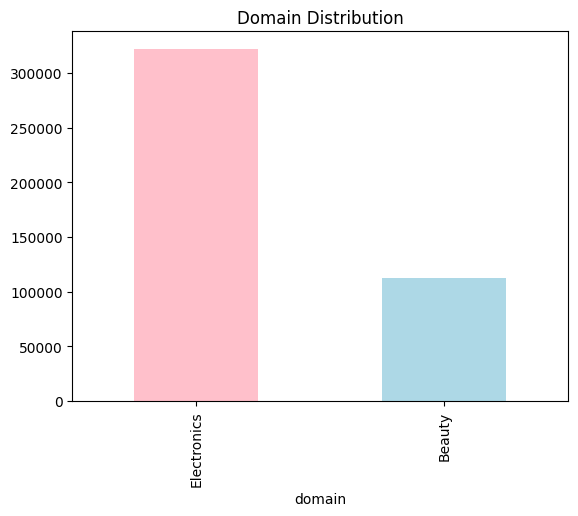

In [10]:

df['domain'].value_counts().plot(kind='bar', title='Domain Distribution', color=['pink', 'lightblue'])
plt.show()

---

## **2. Text Length Distribution**

We compute the length (in characters) of the `combined_text` field to evaluate:

* Whether products contain meaningful descriptions
* How consistent the text data is across domains
* Whether there are extreme outliers that could distort embeddings

Key observations from the histogram:

* The vast majority of entries have **short to moderate text lengths**
* A few very long descriptions exist (thousands of characters), but they do not dominate
* This confirms our combined text field is appropriate for embedding models, which perform best with concise structured inputs

This step also helps determine whether we need truncation, normalization, or text cleaning before embedding.


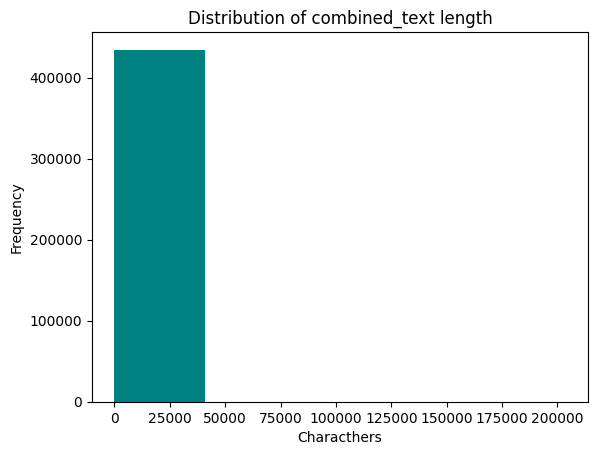

In [11]:
df['text_lenght'] = df['combined_text'].str.len()
plt.hist(df['text_lenght'], bins=5, color='teal')
plt.title('Distribution of combined_text length')
plt.xlabel('Characthers')
plt.ylabel('Frequency')
plt.show()


---

## **3. Price & Average Rating Analysis**

### **Price Cleaning**

Many price values come in inconsistent text formats (e.g., `"EUR 29.99"` or `"29.99"`).
We convert them into clean numeric floats using a custom `convert_price()` function that:

* Removes currency symbols
* Gracefully handles missing or malformed prices
* Produces consistent numeric values

Rows with invalid or missing price values are removed for analysis.

In [12]:
def convert_price(price_str: str) -> float|None:
    if price_str == "None" or pd.isna(price_str):
        return np.nan
    try:
        # Remove EUR and any other currency symbols, spaces
        clean_price = price_str.replace("EUR", "").strip()
        return float(clean_price)
    except (ValueError, AttributeError):
        return np.nan
    
df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
df['price'] = df['price'].apply(convert_price)
df = df.dropna(subset=['price'])

print(df.groupby('domain')[['average_rating', 'price']].describe())

            average_rating                                               \
                     count      mean       std  min  25%  50%  75%  max   
domain                                                                    
Beauty             17704.0  4.171826  0.719444  1.0  3.9  4.3  4.6  5.0   
Electronics       126319.0  4.212594  0.642457  1.0  4.0  4.4  4.6  5.0   

                price                                                    \
                count       mean         std   min    25%    50%    75%   
domain                                                                    
Beauty        17704.0  27.255730   50.472020  0.01   9.99  16.99  29.90   
Electronics  126319.0  89.730122  291.284078  0.00  11.99  21.90  57.99   

                       
                  max  
domain                 
Beauty        2548.98  
Electronics  24996.99  


---

### **Rating & Price Summary**

We compute descriptive statistics grouped by domain, which helps answer:

* Do Beauty and Electronics products differ in average price?
* Are rating distributions similar across domains?
* Are there extreme outliers?

### **Boxplots**




<Axes: xlabel='domain', ylabel='average_rating'>

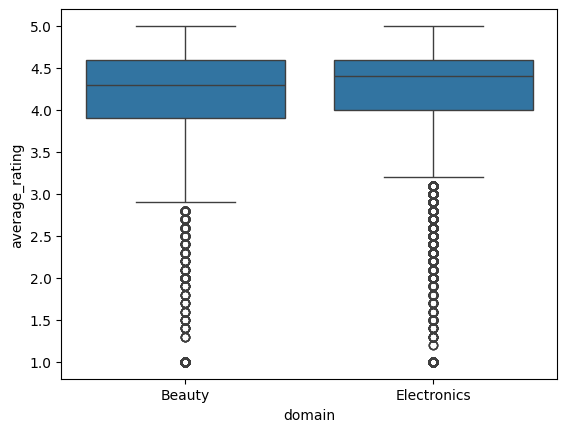

In [13]:
sns.boxplot(x='domain', y='average_rating', data=df)

<Axes: xlabel='domain', ylabel='price'>

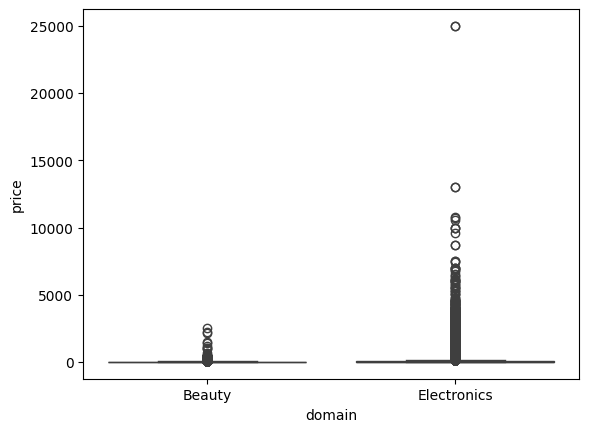

In [14]:
sns.boxplot(x='domain', y='price', data=df)

The boxplots provide a visual comparison:

* **Average Rating:**
  Both domains cluster around typical Amazon-style ratings (4.0–4.5).
  Electronics tends to show slightly more variability.

* **Price:**
  Electronics exhibits a much wider price range due to the presence of high-value items (laptops, cameras, etc.).
  Beauty products are more tightly distributed around low to mid-range prices.

These insights help shape expectations for future user queries—for example, price filtering and domain-aware recommendations.


---

## **Keyword Snapshot**

To better understand the textual characteristics of the dataset, we generate a high-level **keyword snapshot** using word clouds.
This visualization provides an intuitive overview of the dominant terms appearing in product titles, features, and descriptions.

### **Why this matters**

Keyword snapshots help answer important questions early in the pipeline:

* **What vocabulary dominates each domain?**
  Electronics often contains terms like *“USB”, “wireless”, “charger”, “camera”*, while Beauty includes *“serum”, “moisturizer”, “sunscreen”, “hydrating”*.

* **Are there meaningful differences between product categories?**
  These differences guide domain-aware retrieval and help improve context understanding for embedding models.

* **Do the texts contain noisy or irrelevant keywords?**
  Identifying unwanted tokens early allows us to refine cleaning steps if necessary.

### **How it helps the RAG pipeline**

Word clouds are not for modeling—but they give a quick diagnostic check on:

* Vocabulary richness
* Thematic consistency
* Presence of technical vs descriptive language
* Potential token-dominance issues (e.g., overly repeated marketing words)

Understanding this textual landscape ensures that the **embedding model captures meaningful semantic signals**, rather than noise or overly repetitive wording.


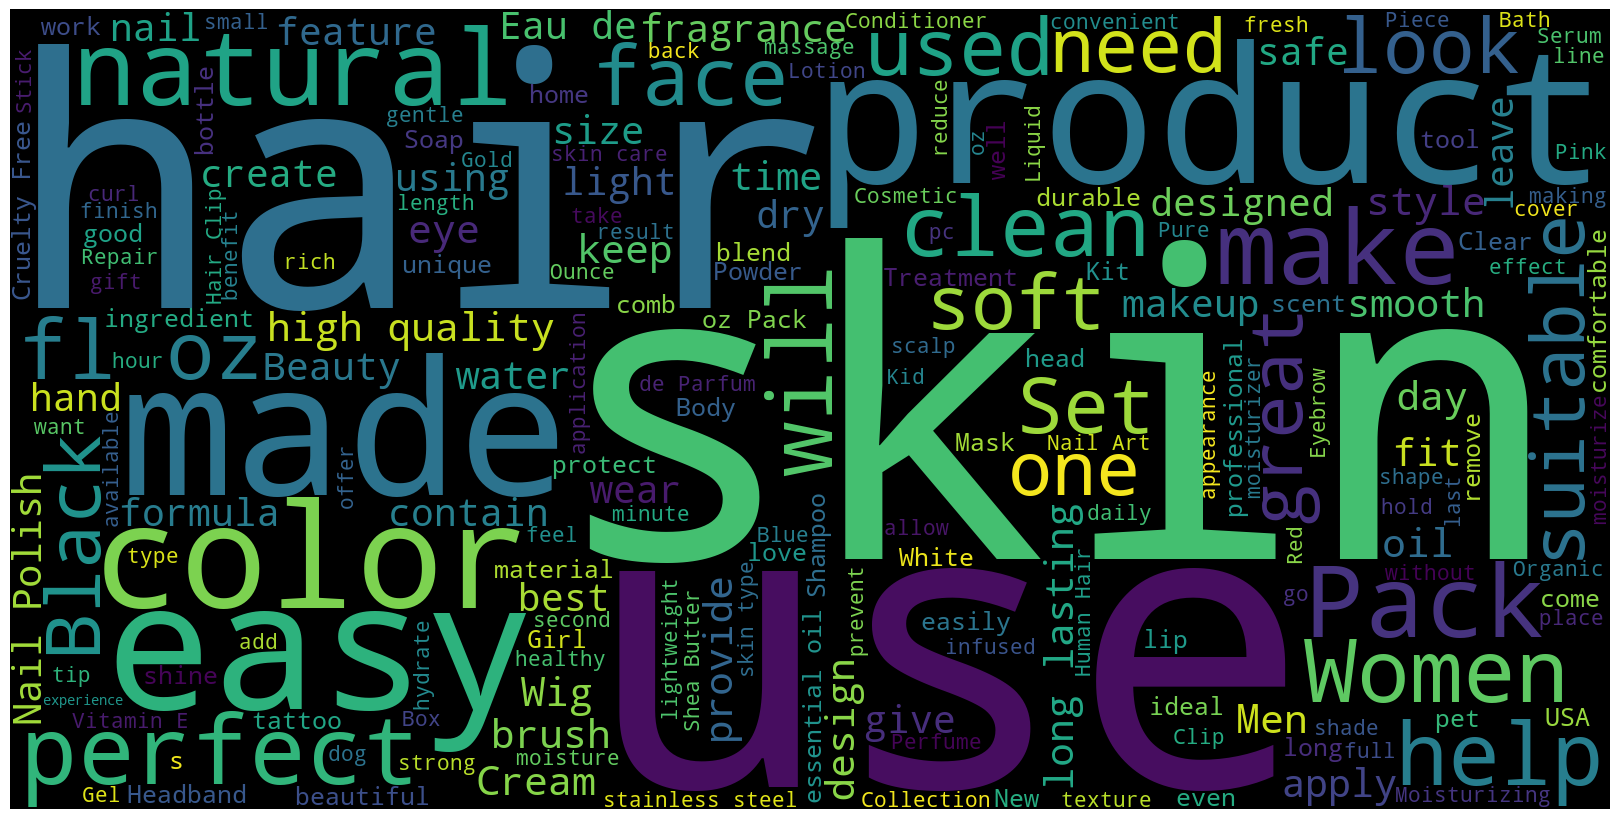

In [15]:
from wordcloud import WordCloud
beauty_text = " ".join(df[df['domain']=="Beauty"]['combined_text'].tolist())

plt.figure(figsize=(16, 8))
wordcloud = WordCloud(width=1600, height=800, background_color='black').generate(beauty_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.tight_layout(pad=0)
plt.show()

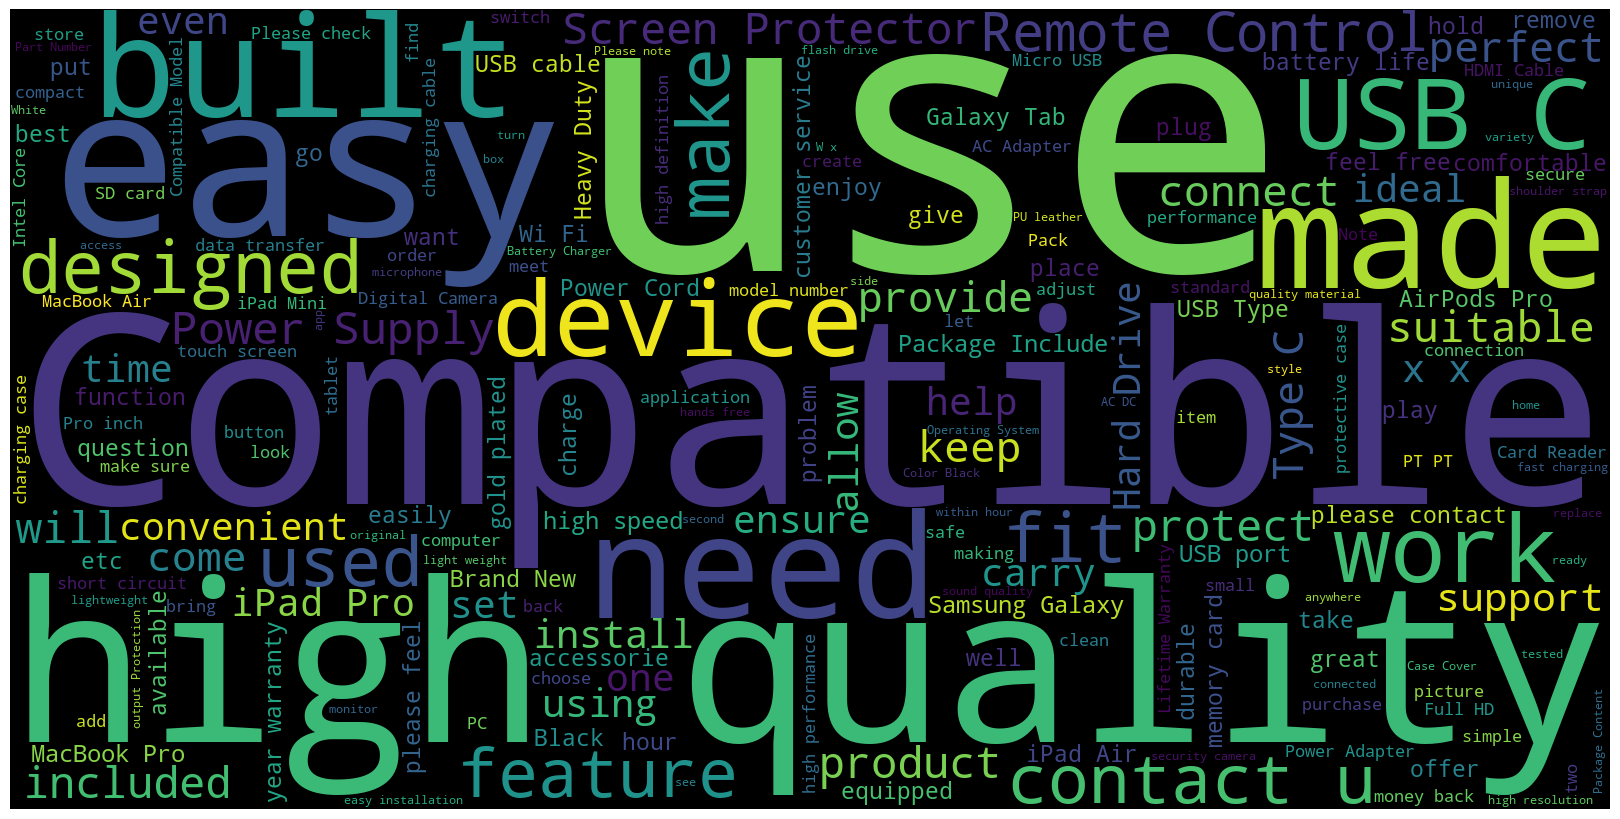

In [18]:
electronic_text = " ".join(df[df['domain']=="Electronics"]['combined_text'].tolist())
plt.figure(figsize=(16, 8))
wordcloud = WordCloud(width=1600, height=800, background_color='black').generate(electronic_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.tight_layout(pad=0)
plt.show()


### **What we observe**

* **Electronics** tends to highlight technical attributes (e.g., *“wireless”, “portable”, “USB”, “battery”*).
* **Beauty** emphasizes ingredients, effects, and usage (e.g., *“hydrating”, “serum”, “spf”, “cream”, “mask”*).
* These patterns confirm that the dataset is diverse and semantically rich—ideal for building a product-focused retrieval system.


---

### Save dataset with the main columns


In [19]:
columns_to_keep.append("combined_text")
df = df[columns_to_keep]
print(df.shape)
# df.to_parquet(os.path.join(WORKED_FOLDER, "cleaned_full_corpus.parquet"), index=False)


(144023, 9)



---

## 🎯 **Final Dataset Summary**

After completing the cleaning, transformation, and exploratory analysis steps, we now have a **fully structured, high-quality dataset** ready for embedding generation and semantic retrieval.
This improved dataset resolves the common issues found in raw Amazon-style product data, such as inconsistent formats, mixed data types, missing values, and noisy text fields.

### **Key Improvements Made**

* Standardized text fields (title, features, description)
* Converted lists/arrays into clean strings
* Removed malformed or missing price entries
* Normalized numeric fields (ratings & prices)
* Added domain labels and keyword-based Beauty categories
* Constructed a unified `combined_text` field optimized for embeddings
* Explored distributions to validate quality and catch anomalies
* Verified domain balance and text length ranges
* Performed price & rating diagnostics per domain

These steps ensure that **every remaining row** contains meaningful, structured information suitable for downstream ML tasks.

---

## **Final Dataset Snapshot**

* **Total rows:** ~ *144023 rows*

* **Domains included:** Beauty & Electronics

* **Core columns retained:**

  * `title`
  * `description`
  * `features`
  * `main_category`
  * `categories`
  * `price`
  * `average_rating`
  * `combined_text`
  * `domain`

* **Text field quality:**
  All product entries now contain a consolidated, readable, and well-formatted text description suitable for vectorization.

* **Price and rating fields:**
  Fully numeric and free from formatting inconsistencies.

---

## **Why This Dataset Is Now RAG-Ready**

The final dataset is optimized for **retrieval-augmented generation**, semantic search, and recommendation models:

* The `combined_text` field provides rich product context.
* Clean numeric metadata enables filtering (e.g., price range, rating).
* Balanced and well-structured domain information supports domain-aware retrieval.
* Noise reduction improves embedding quality and search precision.

---

## **Conclusion**

This cleaned dataset forms the foundation of the entire product-recommendation pipeline.
Its consistent structure, rich textual content, and normalized metadata ensure that the next steps—embedding generation, vector indexing, model evaluation, and application development—operate reliably and efficiently.

---


**End of Notebook**